In [1]:
pip install cobra

In [2]:
import numpy as np

import matplotlib.pyplot as pyplot
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
import pandas as pd
from cobra.io import load_matlab_model
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

from scipy.stats import wasserstein_distance


#loc = '/content/drive/MyDrive/Colab Notebooks/MTP/New_2/'

In [3]:
RS_g5_ctrl = load_matlab_model('RS_g5_ctrl.mat')
RS_g5_MG = load_matlab_model('RS_g5_MG.mat')
samples_g5_ctrl = pd.read_csv('samples_g5_ctrl.csv')
samples_g5_MG = pd.read_csv('samples_g5_MG.csv')

RS_g25_ctrl = load_matlab_model('RS_g25_ctrl.mat')
RS_g25_MG = load_matlab_model('RS_g25_MG.mat')
samples_g25_ctrl = pd.read_csv('samples_g25_ctrl.csv')
samples_g25_MG = pd.read_csv('samples_g25_MG.csv')

No defined compartments in model RS_g5_ctrl. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, l, m, n, r, v, x
No defined compartments in model RS_g5_MG. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, l, m, n, r, v, x
No defined compartments in model RS_g25_ctrl. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, l, m, n, r, v, x
No defined compartments in model RS_g25_MG. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, l, m, n, r, v, x


In [4]:
g5_ctrl_generxnS = pd.read_csv('RS_g5_ctrl_symbol_file.csv')
g25_ctrl_generxnS = pd.read_csv('RS_g25_ctrl_symbol_file.csv')

g5_ctrl_generxn = pd.read_csv('RS_g5_ctrl_genes_file.csv')
g25_ctrl_generxn = pd.read_csv('RS_g25_ctrl_genes_file.csv')


In [5]:
def fluxsampling_dys_data(ctrl,MG,samples_ctrl,samples_MG,ctrl_generxn,ctrl_generxnS,div):

    A = samples_ctrl.columns
    B = samples_MG.columns
    inter = [item for item in A if item in B]

    I=[]
    for i in range(0,len(A)):
        if A[i] in inter:
            I.append(i)


    Dys = [];P = [];up = 0;down = 0;Up = [];Down = [];Up_P = [];Down_P = [];Up_rxnname = [];Down_rxnname = [];
    n = 0;N = [];m = 0;Down_N = [];Up_N = []; Down_genename =[]; Up_genename = []; Down_genenames =[]; Up_genenames =[];
    Down_median = []; Up_median = [];nodys_median=[];

    Down_div=[];Up_div=[]; nodys=[];nodys_N=[];nodys_div=[];nodys_P=[];Down_geneS=[];Up_geneS=[];nodys_rxnname = []; nodys_genename=[]; nodys_geneS = [];nodys_genenames= []; nodys_genenames = [];

    for j in range(0,len(inter)):
        i = inter[j]
        x = samples_ctrl[i]
        y = samples_MG[i]
        stat, p = mannwhitneyu(x, y)
        dive = find_div(x,y,div)
        median = np.median(x) - np.median(y)
        if p < 0.005:
            Dys.append(i)
            if stat < len(x) * len(y) / 2:
                
                if float(dive) >0.5:
                    Up.append(i)
                    Up_N.append(I[j]+1)
                    Up_div.append(dive)
                    Up_P.append(p)
                    Up_median.append(median)
                else:
                    nodys.append(i)
                    nodys_N.append(I[j]+1)
                    nodys_div.append(dive)
                    nodys_P.append(p)
                    nodys_median.append(median)
            else:
                #dive = find_div(x,y,div)
                if float(dive) > 0.5:
                    Down.append(i)
                    Down_N.append(I[j]+1)
                    Down_div.append(dive)
                    Down_P.append(p)
                    Down_median.append(median)
                else:
                    nodys.append(i)
                    nodys_N.append(I[j]+1)
                    nodys_div.append(dive)
                    nodys_P.append(p)
                    nodys_median.append(median)
        else:
            nodys.append(i)
            nodys_N.append(I[j]+1)
            nodys_div.append(dive)
            nodys_P.append(p)
            nodys_median.append(median)

    C = ctrl_generxn.columns
    D = ctrl_generxnS.columns

    for i in range(0,len(Down)):
        Down_rxnname.append(ctrl.reactions[Down_N[i]-1].name)
        gene = ctrl_generxn[C[Down_N[i]-1]]
        geneS = ctrl_generxnS[D[Down_N[i]-1]]
        gene_name = []
        gene_S = []
        for item in gene:
            if(str(item) != "nan"):
                gene_name.append(item)
        for item in geneS:
            if(str(item) != "nan"):
                gene_S.append(item)
        n = len(gene_name)
        m = len(Down_genenames)
        Down_genename.append(gene_name)
        Down_geneS.append(gene_S)


    for i in range(0,len(Up)):

        Up_rxnname.append(ctrl.reactions[Up_N[i]-1].name)
        gene = ctrl_generxn[C[Up_N[i]-1]]
        geneS = ctrl_generxnS[D[Up_N[i]-1]]
        gene_name = []
        gene_S = []
        for item in gene:
            if(str(item) != "nan"):
                gene_name.append(item)
        for item in geneS:
            if(str(item) != "nan"):
                gene_S.append(item)
        n = len(gene_name)
        m = len(Up_genenames)
        Up_genename.append(gene_name)
        Up_geneS.append(gene_S)

    for i in range(0,len(nodys)):

        nodys_rxnname.append(ctrl.reactions[nodys_N[i]-1].name)
        gene = ctrl_generxn[C[nodys_N[i]-1]]
        geneS = ctrl_generxnS[D[nodys_N[i]-1]]
        gene_name = []
        gene_S = []
        for item in gene:
            if(str(item) != "nan"):
                gene_name.append(item)
        for item in geneS:
            if(str(item) != "nan"):
                gene_S.append(item)
        n = len(gene_name)
        m = len(nodys_genenames)
        nodys_genename.append(gene_name)
        nodys_geneS.append(gene_S)


    Down_data = {'rxns': Down,
                'p_value': Down_P,
                'rxnname': Down_rxnname,
                'divergence': Down_div,
                'median' : Down_median,
                'genename': Down_genename,
                'geneSymbol': Down_geneS}
    Down_df = pd.DataFrame(Down_data)

    Up_data = {'rxns': Up,
                'p_value': Up_P,
                  'rxnname': Up_rxnname,
               'divergence': Up_div,
               'median' : Up_median,
              'genename': Up_genename,
              'geneSymbol': Up_geneS}
    Up_df = pd.DataFrame(Up_data)

    nodys_data = {'rxns': nodys,
                'p_value': nodys_P,
                  'rxnname': nodys_rxnname,
               'divergence': nodys_div,
                  'median' : nodys_median,
              'genename': nodys_genename,
              'geneSymbol': nodys_geneS}
    nodys_df = pd.DataFrame(nodys_data)

    Down_df = Down_df.sort_values(by=['divergence'],ascending = False,ignore_index=True)
    Up_df = Up_df.sort_values(by=['divergence'],ascending =False,ignore_index=True)
    nodys_df = nodys_df.sort_values(by=['divergence'],ascending =False,ignore_index=True)

    Down_geneSymbol = [];
    for i in range(0,len(Down)):
        gene_name = Down_df.genename[i]
        gene_S = Down_df.geneSymbol[i]
        n = len(gene_name)
        m = len(Down_genenames)
        Down_genenames[m:m+n] = gene_name[0:n]
        Down_geneSymbol[m:m+n] = gene_S[0:n]

    Down_genes_df = { 'down_genes' : (np.transpose((genes_sort(Down_genenames))[0])),
                   'down_genesymbol' : (np.transpose((genes_sort(Down_geneSymbol))[0]))}

    Down_genenames_df = pd.DataFrame(Down_genes_df)

    

    Up_geneSymbol = [];
    for i in range(0,len(Up)):
        gene_name = Up_df.genename[i]
        gene_S = Up_df.geneSymbol[i]
        n = len(gene_name)
        m = len(Up_genenames)
        Up_genenames[m:m+n] = gene_name[0:n]
        Up_geneSymbol[m:m+n] = gene_S[0:n]
    
    #Up_genenames = np.transpose((genes_sort(Up_genenames))[0])
    #Up_geneSymbol = np.transpose((genes_sort(Up_geneSymbol))[0])
    

    
    Up_genes_df = {'Up_genes' : (np.transpose((genes_sort(Up_genenames))[0])),
                   'Up_genesymbol' : (np.transpose((genes_sort(Up_geneSymbol))[0]))}
    
    
    Up_genenames_df = pd.DataFrame(Up_genes_df)

    nodys_geneSymbol = [];
    for i in range(0,len(nodys)):
        gene_name = nodys_df.genename[i]
        gene_S = nodys_df.geneSymbol[i]
        n = len(gene_name)
        m = len(nodys_genenames)
        nodys_genenames[m:m+n] = gene_name[0:n]
        nodys_geneSymbol[m:m+n] = gene_S[0:n]
    #nodys_genenames = np.transpose((genes_sort(nodys_genenames))[0])
    #nodys_geneSymbol = np.transpose((genes_sort(nodys_geneSymbol))[0])
    
  
    
    nodys_genes_df = { 'nodys_genes' : (np.transpose((genes_sort(nodys_genenames))[0])),
                   'nodys_genesymbol' : (np.transpose((genes_sort(nodys_geneSymbol))[0]))}
    nodys_genenames_df = pd.DataFrame(nodys_genes_df)

    return [Down_df,Up_df,nodys_df,Down_genenames_df,Up_genenames_df,nodys_genenames_df]


def genes_sort(all_genes):
        _, idx = np.unique(all_genes, return_index=True)
        sort_idx = np.sort(idx)
        sorted_genes = [all_genes[i] for i in sort_idx]

        return [sorted_genes]


def find_div(x,y,div):

        if div == 'kl_divergence':
                return (np.mean(np.mean(kl_div(x+1000, y+1000))+np.mean(kl_div(y+1000,x+1000))))
        elif div == 'js_divergence':
                return jensenshannon(x, y)
        elif div == 'emd_dis':
                return wasserstein_distance(x, y)



In [6]:
div_test = 'kl_divergence'

[g5_Down_df,g5_Up_df,g5_nodys_df,g5_Down_genes,g5_Up_genes,g5_nodys_genes] = fluxsampling_dys_data(RS_g5_ctrl,RS_g5_MG,samples_g5_ctrl,samples_g5_MG,g5_ctrl_generxn,g5_ctrl_generxnS,div_test)

[g25_Down_df,g25_Up_df,g25_nodys_df,g25_Down_genes,g25_Up_genes,g25_nodys_genes] = fluxsampling_dys_data(RS_g25_ctrl,RS_g25_MG,samples_g25_ctrl,samples_g25_MG,g25_ctrl_generxn,g25_ctrl_generxnS,div_test)


with pd.ExcelWriter('rxn_dysdata.xlsx') as writer:
    # Write each DataFrame to a different sheet
    g5_Down_df.to_excel(writer, sheet_name='g5_Down', index=False)
    g5_Up_df.to_excel(writer, sheet_name='g5_Up', index=False)
    g5_nodys_df.to_excel(writer, sheet_name='g5_nodys', index=False)
    
    g25_Down_df.to_excel(writer, sheet_name='g25_Down', index=False)
    g25_Up_df.to_excel(writer, sheet_name='g25_Up', index=False)
    g25_nodys_df.to_excel(writer, sheet_name='g25_nodys', index=False)



with pd.ExcelWriter('gene_dysdata.xlsx') as writer:
    g5_Down_genes.to_excel(writer, sheet_name='g5_Down', index=False)
    g5_Up_genes.to_excel(writer, sheet_name='g5_Up', index=False)
    g5_nodys_genes.to_excel(writer, sheet_name='g5_nodys', index=False)
    
    g25_Down_genes.to_excel(writer, sheet_name='g25_Down', index=False)
    g25_Up_genes.to_excel(writer, sheet_name='g25_Up', index=False)
    g25_nodys_genes.to_excel(writer, sheet_name='g25_nodys', index=False)

   

In [ ]:
#Adipose
[g25_Down_df,g25_Up_df,g25_nodys_df,g25_Down_genes,g25_Up_genes,g25_nodys_genes] = fluxsampling_dys_data(RS_g25_ctrl,RS_g25_MG,samples_g25_ctrl,samples_g25_MG,g25_ctrl_generxn,g5_ctrl_generxnS,div_test)

g25_Down_df.to_csv('g25_down.csv', index=False)
g25_Up_df.to_csv('g25_up.csv', index=False)

g25_down_sgenes = { 'down_genes' : (np.transpose((genes_sort(g25_Down_genes))[0]))}
g25_up_sgenes = { 'up_genes' : (np.transpose((genes_sort(g25_Up_genes))[0]))}

g25_down_sgenes_df = pd.DataFrame(g25_down_sgenes)
g25_Up_genes = pd.DataFrame(g25_up_sgenes)

g25_down_sgenes_df.to_csv('g25_down_genes.csv', index=False)
g25_up_sgenes_df.to_csv('g25_up_genes.csv', index=False)



In [ ]:
AD_Down_df.divergence

0       1092.883211
1       1087.204562
2       1075.338491
3       1019.745768
4       1011.185961
           ...     
1637       0.502088
1638       0.502065
1639       0.502065
1640       0.501640
1641       0.501640
Name: divergence, Length: 1642, dtype: float64

In [ ]:
print(g5_Down_df.head())
print(len(g5_Down_df))
print(g5_Down_df.tail())

        rxns  p_value                                            rxnname  \
0   AD_C2tcx      0.0  Transport of Acetylcarnitine from Peroxisomes ...   
1  AD_CSNATp      0.0  Carnitine O-Acetyltransferase, Reverse Directi...   
2  AD_CITtam      0.0                   Citrate Transport, Mitochondrial   
3   AD_r0819      0.0         Mitochondrial Carrier (Mc) Tcdb:2.A.29.2.2   
4  AD_GLCt1r      0.0                        Glucose Transport (Uniport)   

           div                                           genename  
0  2092.537558               [solute carrier family 25 member 20]  
1  1508.043822                    [carnitine O-acetyltransferase]  
2  1435.779774                [solute carrier family 25 member 1]  
3  1298.244043               [solute carrier family 25 member 10]  
4  1248.893820  [solute carrier family 2 member 6, solute carr...  
727
            rxns        p_value                                      rxnname  \
722     AD_r2396   0.000000e+00  Mitochondrial Carr

In [ ]:
import numpy as np
from scipy.special import kl_div

def compute_kl_divergence(p, q, epsilon):
    # Add epsilon to distributions to avoid zero probabilities
    p_smoothed = p + epsilon
    q_smoothed = q + epsilon

    # Compute KL divergence
    kl_divergence = kl_div(p_smoothed, q_smoothed)
    return kl_divergence

def normalize_scores(scores):
    # Min-max scaling to normalize scores between 0 and 1
    min_score = np.min(scores)
    max_score = np.max(scores)
    normalized_scores = (scores - min_score) / (max_score - min_score)
    return normalized_scores

# Example distributions
p = np.array([0.2, 0.3, 0.0, 0.5])  # Distribution P
q = np.array([0.3, 0.3, 0.4, 0.0])  # Distribution Q

# Set epsilon
epsilon = 1000

# Compute KL divergence
kl_divergence = compute_kl_divergence(x, y, epsilon)
print("KL Divergence:", kl_divergence)

# Normalize scores
normalized_kl_divergence = normalize_scores([kl_divergence])
print("Normalized KL Divergence:", normalized_kl_divergence)


KL Divergence: 0       3.205969e-10
1       4.678668e-09
2       1.416038e-08
3       1.836520e-08
4       6.548134e-09
            ...     
9995    6.405386e-03
9996    4.381871e-03
9997    1.060982e-02
9998    2.558386e-02
9999    9.928541e-03
Name: EX_Bl_dca3g[e], Length: 10000, dtype: float64
Normalized KL Divergence: [[1.88474844e-09 2.75964732e-08 8.35366118e-08 ... 6.25957781e-02
  1.50939502e-01 5.85763545e-02]]


In [ ]:
normalized_kl_divergence = normalize_scores([AD_Down_df.div])
print("Normalized KL Divergence:", normalized_kl_divergence)

TypeError: unsupported operand type(s) for -: 'list' and 'method'

In [ ]:
[g5_Down_df,g5_Up_df,g5_Down_genes,g5_Up_genes] = fluxsampling_dys_data(RS_g5_ctrl,RS_g5_MG,samples_g5_ctrl,samples_g5_MG,g5_ctrl_generxn,g5_ctrl_generxnS,'js_divergence')
print(g5_Down_df.head())
print(len(g5_Down_df))
print(g5_Down_df.tail())

               rxns       p_value  \
0         AD_NMNATr  0.000000e+00   
1     AD_DOPAt4_2_r  1.752853e-16   
2  AD_sink_leu_L[c]  1.674069e-61   
3        AD_4ABUTtm  0.000000e+00   
4         AD_ABTArm  0.000000e+00   

                                             rxnname       div  \
0        Nicotinamide-Nucleotide Adenylyltransferase  0.283524   
1  Transport of Dopamine  via Sodium Symport (1:2...  0.273234   
2                                      Sink_leu_L[c]  0.218608   
3  4-Aminobutanoate Mitochondrial Transport via D...  0.198624   
4  4-Aminobutyrate Transaminase, Reversible, Mito...  0.198624   

                                            genename  
0  [nicotinamide nucleotide adenylyltransferase 2...  
1  [solute carrier family 6 member 2, solute carr...  
2                                                 []  
3                                                 []  
4  [4-aminobutyrate aminotransferase, 4-aminobuty...  
2158
                       rxns       p_value  \


In [ ]:

[g5_Down_df,g5_Up_df,g5_Down_genes,g5_Up_genes] = fluxsampling_dys_data(RS_g5_ctrl,RS_g5_MG,samples_g5_ctrl,samples_g5_MG,g5_ctrl_generxn,g5_ctrl_generxnS,'emd_dis')
print(g5_Down_df.head())
print(len(g5_Down_df))
print(g5_Down_df.tail())

        rxns  p_value                                            rxnname  \
0  AD_CYTK11      0.0                     Cytidylate Kinase (dCMP, dGTP)   
1  AD_CITtam      0.0                   Citrate Transport, Mitochondrial   
2   AD_C2tcx      0.0  Transport of Acetylcarnitine from Peroxisomes ...   
3   AD_r0819      0.0         Mitochondrial Carrier (Mc) Tcdb:2.A.29.2.2   
4  AD_CSNATp      0.0  Carnitine O-Acetyltransferase, Reverse Directi...   

           div                                   genename  
0  1092.883211  [cytidine/uridine monophosphate kinase 1]  
1  1087.204562        [solute carrier family 25 member 1]  
2  1075.338491       [solute carrier family 25 member 20]  
3  1019.745768       [solute carrier family 25 member 10]  
4  1011.185961            [carnitine O-acetyltransferase]  
2158
                       rxns       p_value  \
2153      AD_sink_dd2coa[c]  1.088049e-11   
2154           AD_S6TASE9ly  1.170733e-07   
2155           AD_NACHEX9ly  1.170733e-07  

In [ ]:
kl_divergence = np.sum(kl_div(x, y))
print("KL divergence:", kl_divergence)

KL divergence: 14352.278403509517


In [ ]:
kl_divergence = np.sum(kl_div(y,x))
print("KL divergence:", kl_divergence)

KL divergence: 12809.72344304559


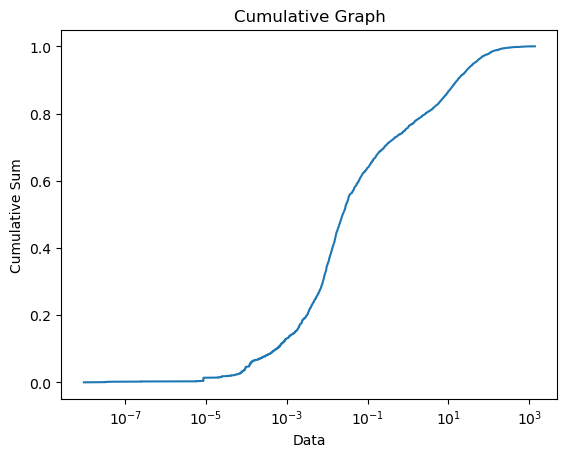

In [ ]:
A = RS_g5_ctrl.columns
B = RS_g5_MG.columns
inter = [item for item in A if item in B]

I=[]
for i in range(0,len(A)):
    if A[i] in inter:
        I.append(i)

kl_dive = []
for j in range(0,len(inter)):
    i = inter[j]
    x = AD_CT[i]
    y = AD_PC[i]
    kl_dive.append(np.mean(kl_div(x+1000, y+1000)))

my_list=[]
for k in kl_dive:
    if k !=float('inf'):
        my_list.append(k)
my_list

#pyplot.hist(my_list)

# Sort the data
sorted_ = np.sort(kl_dive)
sorted_data = sorted_

# Compute the cumulative sum
#cumulative_sum = np.cumsum(sorted_data)
cumulative_percent = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plot the cumulative graph
plt.plot(sorted_data, cumulative_percent)
plt.xscale('log')
# Add labels and title
plt.xlabel('Data')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Graph')

# Show the plot

plt.show()

In [ ]:
import numpy as np
from scipy.special import kl_div

def compute_kl_divergence(p, q, epsilon):
    # Add epsilon to distributions to avoid zero probabilities
    p_smoothed = p + epsilon
    q_smoothed = q + epsilon

    # Compute KL divergence
    kl_divergence = kl_div(p_smoothed, q_smoothed)
    return kl_divergence

def scale_scores(scores, min_value, max_value):
    # Scale scores to the specified range
    scaled_scores = (scores - np.min(scores)) * (max_value - min_value) / (np.max(scores) - np.min(scores)) + min_value
    return scaled_scores

# Example distributions
p = np.array([0.2, 0.3, 0.0, 0.5])  # Distribution P
q = np.array([0.3, 0.3, 0.4, 0.0])  # Distribution Q

# Set epsilon
epsilon = 1000

# Compute KL divergence
kl_divergence = compute_kl_divergence(x, y, epsilon)
print("KL Divergence:", kl_divergence)

# Scale scores to a specific range
min_value = -1  # Minimum value for scaling
max_value = 1   # Maximum value for scaling
scaled_kl_divergence = scale_scores(np.array([kl_divergence]), min_value, max_value)
print("Scaled KL Divergence:", scaled_kl_divergence)


KL Divergence: 0       3.205969e-10
1       4.678668e-09
2       1.416038e-08
3       1.836520e-08
4       6.548134e-09
            ...     
9995    6.405386e-03
9996    4.381871e-03
9997    1.060982e-02
9998    2.558386e-02
9999    9.928541e-03
Name: EX_Bl_dca3g[e], Length: 10000, dtype: float64
Scaled KL Divergence: [[-1.         -0.99999994 -0.99999983 ... -0.87480844 -0.698121
  -0.88284729]]


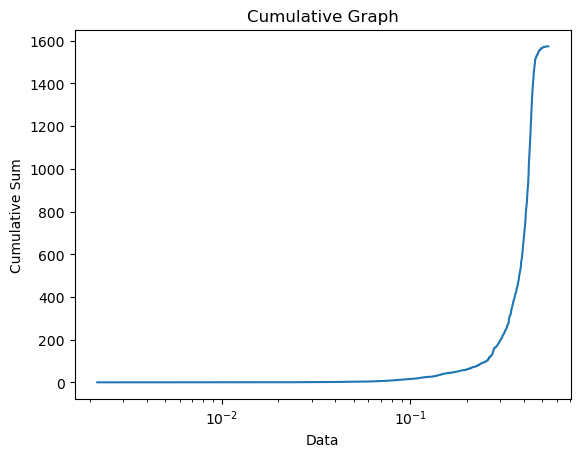

In [ ]:
A = RS_g5_ctrl.columns
B = RS_g5_MG.columns
inter = [item for item in A if item in B]

I=[]
for i in range(0,len(A)):
    if A[i] in inter:
        I.append(i)

js_dive = []
for j in range(0,len(inter)):
    i = inter[j]
    x = AD_CT[i]
    y = AD_PC[i]
    epsilon = 10  # Small constant (adjust as needed)

    js_dive.append(jensenshannon(x, y))
    if js_dive[j] == float('inf'):
        x_smoothed = x + epsilon
        y_smoothed = y + epsilon
        js_dive[j]=jensenshannon(x_smoothed, y_smoothed)

my_list=[]
for k in js_dive:
    if k !=float('inf'):
        my_list.append(k)
my_list

#pyplot.hist(my_list)

# Sort the data
sorted_ = np.sort(my_list)
sorted_data = sorted_

# Compute the cumulative sum
cumulative_sum = np.cumsum(sorted_data)
cumulative_percent = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plot the cumulative graph
plt.plot(sorted_data, cumulative_sum)
#plt.plot(sorted_data, cumulative_percent)
plt.xscale('log')
# Add labels and title
plt.xlabel('Data')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Graph')

# Show the plot

plt.show()

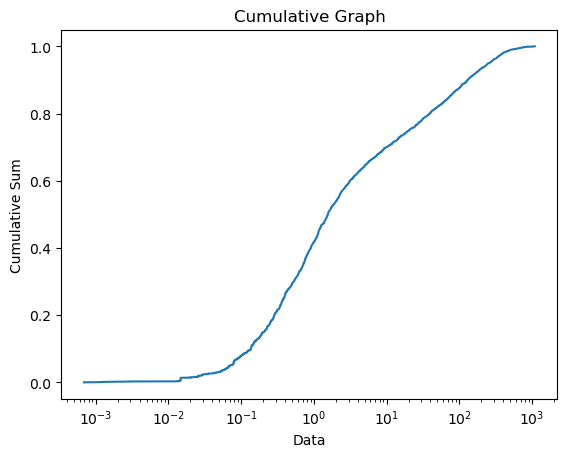

In [ ]:
A = RS_g5_ctrl.columns
B = RS_g5_MG.columns
inter = [item for item in A if item in B]

I=[]
for i in range(0,len(A)):
    if A[i] in inter:
        I.append(i)

emd_distance = []
for j in range(0,len(inter)):
    i = inter[j]
    x = AD_CT[i]
    y = AD_PC[i]
    epsilon = 10  # Small constant (adjust as needed)

    emd_distance.append(wasserstein_distance(x, y))

my_list=[]
for k in emd_distance:
    if k !=float('inf'):
        my_list.append(k)
my_list

#pyplot.hist(my_list)

# Sort the data
sorted_ = np.sort(my_list)
sorted_data = sorted_

# Compute the cumulative sum
#cumulative_sum = np.cumsum(sorted_data)
cumulative_percent = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plot the cumulative graph
#plt.plot(sorted_data, cumulative_sum)
plt.plot(sorted_data, cumulative_percent)
plt.xscale('log')
# Add labels and title
plt.xlabel('Data')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Graph')

# Show the plot

plt.show()

In [ ]:
statistic, p_value = mannwhitneyu(AD_CT[inter[1]], AD_PC[inter[1]])
if p_value < 0.05:
    print("There is a significant difference between the distributions.")
    if statistic < len(AD_CT) * len(AD_PC) / 2:
        print("Treatment distribution is upregulated compared to the control.")
    else:
        print("Treatment distribution is downregulated compared to the control.")
else:
    print("There is no significant difference between the distributions.")
kl_divergence = np.sum(kl_div(AD_CT[inter[1]], AD_PC[inter[1]]))
print("KL Divergence:", kl_divergence)

There is a significant difference between the distributions.
Treatment distribution is downregulated compared to the control.
KL Divergence: 14352.278403509517


In [ ]:
RS_g5_ctrl.reactions

[<Reaction 10FTHF7GLUtl at 0x2c5576abf40>,
 <Reaction 10FTHF7GLUtm at 0x2c557816e80>,
 <Reaction 10FTHFtl at 0x2c557816f10>,
 <Reaction 13DAMPPOX at 0x2c557816fa0>,
 <Reaction 2AMACHYD at 0x2c55784c280>,
 <Reaction 2DR1PP at 0x2c55784c1c0>,
 <Reaction 2HBO at 0x2c55784c100>,
 <Reaction 2HBt2 at 0x2c55784cd60>,
 <Reaction 2HCO3_NAt at 0x2c55784c250>,
 <Reaction 2OXOADOXm at 0x2c55784cdf0>,
 <Reaction 2OXOADPTm at 0x2c55784ca30>,
 <Reaction 34DHOXPEGOX at 0x2c55784c5e0>,
 <Reaction 34DHOXPEGt at 0x2c557850eb0>,
 <Reaction 34DHPHAMT at 0x2c557850e50>,
 <Reaction 34DHPLACOX at 0x2c557850ca0>,
 <Reaction 34DHPLACOX_NADP_ at 0x2c557850d60>,
 <Reaction 34DHXMANDACOX at 0x2c557850850>,
 <Reaction 34DHXMANDACOX_NADP_ at 0x2c557853310>,
 <Reaction 34HPPOR at 0x2c557853a00>,
 <Reaction 3AIBTm at 0x2c557853190>,
 <Reaction 3AIBtmi at 0x2c557853f10>,
 <Reaction 3DPHBH1 at 0x2c557853f70>,
 <Reaction 3DSPHR at 0x2c557853970>,
 <Reaction 3HAO at 0x2c557853fa0>,
 <Reaction 3HBCDm at 0x2c5578534c0>,
 <R

In [ ]:
x = AD_CT['10FTHFtm']
y = AD_PC['10FTHFtm']
stat, p = kruskal(x, y)
pyplot.hist(x, 100, label='RME1+IME1nc+IME1c+RSF1', alpha = 0.5)
pyplot.hist(y, 100,  label='RSF1')
pyplot.legend(loc='upper right')
pyplot.xlabel('Flux')
pyplot.ylabel('Frequency')
pyplot.title('Glucose 6  phosphate dehydrogenase')
pyplot.show()